In [1]:
import torch
import torch.nn as nn
from transformers import DetrImageProcessor, DetrForObjectDetection

class TrackEmbeddingUpdater(nn.Module):
    def __init__(self, num_cameras, embed_dim=256, num_heads=8):
        super().__init__()
        self.num_cameras = num_cameras
        self.cross_attn = nn.ModuleList([
            nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
            for _ in range(num_cameras)
        ])
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(embed_dim, 2048),
            nn.ReLU(),
            nn.Linear(2048, embed_dim)
        )

    def forward(self, track_embeds, detection_embeds):
        attn_outputs = []
        for cam_idx in range(self.num_cameras):
            attn_out, _ = self.cross_attn[cam_idx](
                query=track_embeds,
                key=detection_embeds[cam_idx],
                value=detection_embeds[cam_idx]
            )
            attn_outputs.append(attn_out)
        aggregated = torch.mean(torch.stack(attn_outputs), dim=0)
        self_attn_out, _ = self.self_attn(aggregated, aggregated, aggregated)
        return self.ffn(self_attn_out)

class AssociationModule(nn.Module):
    def __init__(self, embed_dim=256):
        super().__init__()
        self.detection_proj = nn.Linear(embed_dim, embed_dim)
        self.track_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, detection_embeds, track_embeds):
        Q = self.detection_proj(detection_embeds)
        K = self.track_proj(track_embeds)
        return torch.softmax(torch.matmul(Q, K.transpose(1,2)) / (embed_dim**0.5), dim=-1)

class MCTR(nn.Module):
    def __init__(self, num_cameras=4, num_queries=100, embed_dim=256):
        super().__init__()
        self.detr = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")
        self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
        
        self.track_queries = nn.Embedding(num_queries, embed_dim)
        self.track_updater = TrackEmbeddingUpdater(num_cameras, embed_dim)
        self.associator = AssociationModule(embed_dim)
        
        self.detection_proj = nn.Linear(self.detr.config.d_model, embed_dim)
        self.register_buffer('active_tracks', None)

        nn.init.xavier_uniform_(self.track_queries.weight)

    def forward(self, multi_camera_views):
        batch_size = multi_camera_views[0].size(0)
        
        # Inicjalizacja śladów
        if self.active_tracks is None:
            self.active_tracks = self.track_queries.weight.unsqueeze(0).repeat(batch_size, 1, 1)

        # Przetwarzanie DETR dla każdej kamery
        detection_embeds = []
        for view in multi_camera_views:
            inputs = self.processor(images=view, return_tensors="pt").to(view.device)
            outputs = self.detr(**inputs)
            detection_embeds.append(self.detection_proj(outputs.last_hidden_state))

        # Aktualizacja track embeddings
        updated_tracks = self.track_updater(self.active_tracks, detection_embeds)
        
        # Asocjacja detekcji
        assignments = [self.associator(d, updated_tracks) for d in detection_embeds]

        self.active_tracks = updated_tracks.detach()
        return {
            'tracks': updated_tracks,
            'assignments': assignments,
            'detection_embeds': detection_embeds
        }

class MCTRLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.detr_loss = nn.CrossEntropyLoss()
        self.track_loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, outputs, targets):
        # Strata detekcji
        detr_loss = self.detr_loss(
            outputs['detection_logits'], 
            targets['detection_labels']
        )

        # Strata asocjacji
        track_loss = 0
        for cam_assignment, gt_assignment in zip(outputs['assignments'], targets['assignments']):
            track_loss += self.track_loss(
                torch.log(cam_assignment),
                gt_assignment
            )

        return detr_loss + track_loss


C:\Users\SzymonWoźniak(272471\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

In [3]:

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = MCTR().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
# criterion = MCTRLoss()
# dataloader = DataLoader(DummyDataset(), batch_size=2)

# # Pętla treningowa
# for epoch in range(10):
#     for batch in dataloader:
#         views, targets = batch
#         views = [v.to(device) for v in views]
#         targets = {k: v.to(device) for k,v in targets.items()}
        
#         optimizer.zero_grad()
#         outputs = model(views)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
        
#         print(f"Loss: {loss.item():.4f}")

In [4]:
import json
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import DetrImageProcessor

class WildtrackDataset(Dataset):
    def __init__(self, 
                 annotations_dir: str,
                 images_base_dir: str,
                 cameras: dict = {0: 'C1', 5: 'C6'},
                 frame_step: int = 5,
                 max_detections: int = 50):
        
        self.cameras = cameras
        self.frame_step = frame_step
        self.max_detections = max_detections

        # Parsowanie nazw plików JSON: np. 00000000.json, 00000005.json, ...
        self.frame_files = []
        for f in os.listdir(annotations_dir):
            if f.endswith('.json'):
                try:
                    frame_number = int(os.path.splitext(f)[0])
                    self.frame_files.append((f, frame_number))
                except Exception as e:
                    print(f"Ostrzeżenie: Pominięto plik {f} - nieprawidłowy format nazwy")
        
        # Sortuj po numerze klatki
        self.frame_files.sort(key=lambda x: x[1])
        self.frame_files = [f[0] for f in self.frame_files]

        # Wczytaj adnotacje
        self.annotations = []
        for frame_file in self.frame_files:
            with open(os.path.join(annotations_dir, frame_file)) as f:
                frame_data = json.load(f)
                self.annotations.append(self._process_frame(frame_data))
        
        # Przygotuj mapowanie ścieżek do obrazów
        self.image_paths = {}
        for view_num, cam_id in self.cameras.items():
            cam_dir = os.path.join(images_base_dir, cam_id)
            self.image_paths[view_num] = {
                int(os.path.splitext(f)[0]): os.path.join(cam_dir, f)
                for f in os.listdir(cam_dir) 
                if f.endswith('.png')
            }

        self.processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

    def _process_frame(self, frame_data):
        """Przetwarza surowe dane z pliku JSON na format per kamera"""
        frame_anns = {view_num: [] for view_num in self.cameras.keys()}
        
        for person in frame_data:
            for view in person['views']:
                view_num = view['viewNum']
                if view_num in self.cameras and view['xmin'] != -1:
                    bbox = [
                        view['xmin'], 
                        view['ymin'], 
                        view['xmax'] - view['xmin'], 
                        view['ymax'] - view['ymin']
                    ]
                    frame_anns[view_num].append({
                        'bbox': bbox,
                        'track_id': person['personID']
                    })
        
        return frame_anns

    def __len__(self):
        return len(self.frame_files)

    def __getitem__(self, idx):
        # Numer klatki wg nazwy pliku (np. 00000000.json → 0, 00000005.json → 5 itd.)
        frame_number = int(os.path.splitext(self.frame_files[idx])[0])
        
        # Wczytaj obrazy dla wszystkich kamer
        images = {}
        for view_num, cam_id in self.cameras.items():
            img_path = self.image_paths[view_num].get(frame_number)
            if not img_path:
                raise FileNotFoundError(f"Brak obrazu {cam_id} dla klatki {frame_number}")
            
            images[view_num] = Image.open(img_path).convert('RGB')
        
        # Pobierz adnotacje dla klatki
        anns = self.annotations[idx]
        
        # Przygotuj dane wyjściowe
        formatted_anns = {}
        for view_num in self.cameras.keys():
            cam_anns = anns.get(view_num, [])
            
            boxes = torch.zeros((self.max_detections, 4))
            track_ids = torch.zeros(self.max_detections, dtype=torch.long)
            
            for i, ann in enumerate(cam_anns[:self.max_detections]):
                boxes[i] = torch.tensor(ann['bbox'])
                track_ids[i] = ann['track_id']
            
            formatted_anns[view_num] = {
                'boxes': boxes,
                'track_ids': track_ids
            }

        return images, formatted_anns

def custom_collate_fn(batch):
    images_batch, anns_batch = zip(*batch)
    
    # Przetwórz obrazy przez procesor DETR
    processed_images = {}
    for view_num in batch[0][0].keys():
        view_images = [img[view_num] for img in images_batch]
        processed = dataset.processor(images=view_images, return_tensors="pt")
        processed_images[view_num] = {
            'pixel_values': processed['pixel_values'],
            'pixel_mask': processed['pixel_mask']
        }
    
    # Przetwórz adnotacje
    formatted_anns = {
        'detection_labels': {},
        'assignments': {}
    }
    
    for view_num in anns_batch[0].keys():
        all_boxes = torch.stack([anns[view_num]['boxes'] for anns in anns_batch])
        all_track_ids = torch.stack([anns[view_num]['track_ids'] for anns in anns_batch])
        
        formatted_anns['detection_labels'][view_num] = all_boxes
        formatted_anns['assignments'][view_num] = all_track_ids
    
    return processed_images, formatted_anns

# Przykład użycia
dataset = WildtrackDataset(
    annotations_dir='Dataset/annotations_positions',
    images_base_dir='Dataset/image_subsets',
    cameras={0: 'C1', 5: 'C6'},  # viewNum 0 → C1, viewNum 5 → C6
    frame_step=5
)

dataloader = DataLoader(
    dataset,
    batch_size=4,
    collate_fn=custom_collate_fn,
    shuffle=True,
    num_workers=4
)


In [5]:
import os

print("Aktualny folder roboczy:", os.getcwd())

Aktualny folder roboczy: d:\mcmodt\Multi-object-multi-camera-tracking


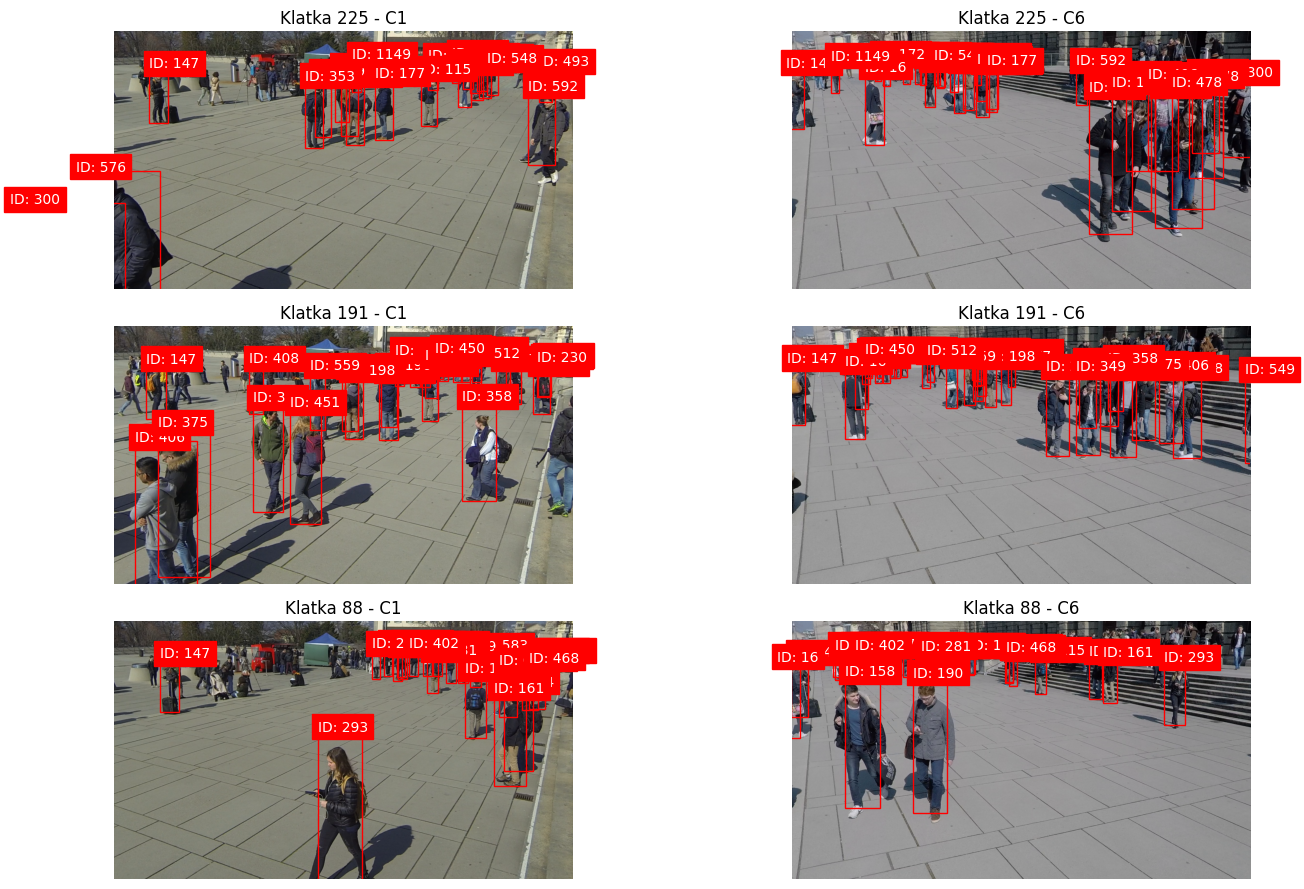

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# 1. Skrypt weryfikacyjny - wizualizacja próbek
def visualize_sample(dataset, num_samples=3):
    fig, axs = plt.subplots(num_samples, len(dataset.cameras), figsize=(15, num_samples*3))
    if num_samples == 1:
        axs = axs.reshape(1, -1)
    
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))
        images, anns = dataset[idx]
        
        for cam_idx, (view_num, cam_id) in enumerate(dataset.cameras.items()):
            ax = axs[i, cam_idx] if num_samples > 1 else axs[cam_idx]
            img = np.array(images[view_num])
            
            # Wyświetl obraz
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f'Klatka {idx} - {cam_id}')
            
            # Narysuj bounding boxy
            for box, track_id in zip(anns[view_num]['boxes'], anns[view_num]['track_ids']):
                if track_id == 0 or torch.all(box == 0):
                    continue
                x, y, w, h = box.numpy()
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=1,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)
                ax.text(x, y, f'ID: {track_id}', color='white', backgroundcolor='red')
    
    plt.tight_layout()
    plt.show()

# Uruchom wizualizację
visualize_sample(dataset, num_samples=3)

# 2. Pełna pętla treningowa
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MCTR(num_cameras=len(dataset.cameras)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = MCTRLoss()

def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    
    for batch_idx, (processed_images, targets) in enumerate(dataloader):
        # Przygotuj dane wejściowe
        inputs = {}
        for view_num in processed_images.keys():
            inputs[view_num] = {
                'pixel_values': processed_images[view_num]['pixel_values'].to(device),
                'pixel_mask': processed_images[view_num]['pixel_mask'].to(device)
            }
        
        # Przygotuj cele
        target_tensors = {
            'detection_labels': {
                view_num: t.to(device) for view_num, t in targets['detection_labels'].items()
            },
            'assignments': {
                view_num: t.to(device) for view_num, t in targets['assignments'].items()
            }
        }
        
        # Reset gradientów
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Oblicz stratę
        loss = criterion(outputs, target_tensors)
        
        # Backpropagacja
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        total_loss += loss.item()
        
        if batch_idx % 10 == 0:
            print(f'Batch {batch_idx}/{len(dataloader)} - Loss: {loss.item():.4f}')
    
    return total_loss / len(dataloader)

# Trening przez 10 epok
num_epochs = 1
for epoch in range(num_epochs):
    avg_loss = train_epoch(model, dataloader, optimizer, criterion, device)
    print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')
    
    # Zapisz model co epokę
    torch.save(model.state_dict(), f'mctr_epoch_{epoch+1}.pth')

print('Trening zakończony!')


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MCTR(num_cameras=len(dataset.cameras)).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = MCTRLoss()

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [1]:
# print(model)

In [ ]:
# Krok 1: Sprawdź czy dataset zwraca poprawne dane
sample_idx = 0
images, anns = dataset[sample_idx]
print(f"Klatka {sample_idx}:")
for view_num in dataset.cameras:
    print(f"Kamera {view_num}:")
    print(f"  Obraz: {images[view_num].size}")
    print(f"  Bboxy: {anns[view_num]['boxes'].shape}")

# Krok 2: Sprawdź czy DataLoader zwraca batch
try:
    test_batch = next(iter(dataloader))
    print("\nBatch testowy:")
    print(f"Liczba kamer: {len(test_batch[0])}")
    print(f"Rozmiar batcha: {test_batch[0][0]['pixel_values'].shape[0]}")
except Exception as e:
    print(f"Błąd w DataLoader: {str(e)}")


Klatka 0:
Kamera 0:
  Obraz: (1920, 1080)
  Bboxy: torch.Size([50, 4])
Kamera 5:
  Obraz: (1920, 1080)
  Bboxy: torch.Size([50, 4])
